In [ ]:
#hide
#not a dep but we need it for show_doc
from nbdev.showdoc import show_doc

In [ ]:
# default_exp vid_stab_orb
# default_cls_lvl 3

# ORB - Simulation of image matching 

> **ORB: An efficient alternative to SIFT or SURF**
>This algorithm was brought up by Ethan Rublee, Vincent Rabaud, Kurt Konolige and Gary R. Bradski in 2011. 
https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html

In [ ]:
# hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import PIL
import numpy as np
import pandas
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from boxsim.trajectory import *

## We choose a large natural image to get image slices to simulate with
> Yosemite_NP_M  (1880 x 2880 x 3)

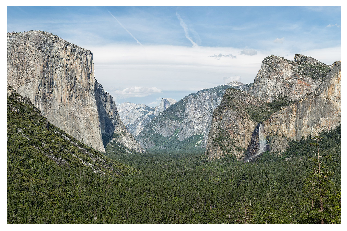

In [ ]:
main_img = np.asarray(PIL.Image.open("Yosemite_NP_M.jpg"))
show_img(main_img)

## Set up an Orb matcher 

In [ ]:
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

FLANN_INDEX_KDTREE = 1
FLANN_INDEX_LSH = 6 
draw_matches_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1) 
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

BF = True
FLANN = False

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
           singlePointColor = None,
            # draw only inliers
           flags = 2)


## Run orb matching tracking and image transform across all the frame in the trajectory

In [ ]:
traj = Trajectory(np.asarray(PIL.Image.open("Yosemite_NP_M.jpg")), 50)
start_img_copy = traj.get_first(scale=1.25)
start_img_copy = cv2.resize(start_img_copy, (600,400))

start_img = np.copy(start_img_copy)
# show_img(start_img,figsize=(10,6))
move_calc = np.zeros((traj.xyza.shape[0], 3))
move_true = np.zeros((traj.xyza.shape[0], 3))
num_kpts = np.zeros(traj.xyza.shape[0], dtype=np.int0)

start_img_gray = cv2.cvtColor(start_img, cv2.COLOR_BGR2GRAY)
kp2, des2 = orb.detectAndCompute(start_img_gray,None)

with FFMPEG_VideoWriter('orb_vid_stab.mp4', (900,300), 24.0) as video:

    for i,f in enumerate(traj):
        cur_img, move_true[i,:] = f
        start_img = np.copy(start_img_copy)
        # find the keypoints and descriptors with ORB
        gray1 = cv2.cvtColor(cur_img, cv2.COLOR_BGR2GRAY)
        # gray2 = cv2.cvtColor(start_img, cv2.COLOR_BGR2GRAY)
        kp1, des1 = orb.detectAndCompute(gray1,None)
        # kp2, des2 = orb.detectAndCompute(gray2,None)
        
        if BF:
            # matches = bf.knnMatch(des1,des2,k=2)
            matches = bf.match(des1,des2)
            good = sorted(matches, key = lambda x:x.distance)
            num_kpts[i] = len(good)
            
        elif FLANN:
            matches = flann.knnMatch(des1,des2,k=2)
            good = []
            try:
                
                for m,n in matches:
                    if m.distance < 0.7*n.distance:
                        good.append(m)
            except:
                print('Error',len(good))
            
        MIN_MATCH_COUNT = 10
        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            h,w,d = start_img.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            start_img = cv2.polylines(start_img,[np.int32(dst)],True,(0,0,255),2, cv2.LINE_AA)
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None
        
    
        img_kps = cv2.drawMatches(cur_img,kp1,start_img,kp2,good,None, matchesMask = matchesMask, **draw_params)
        
        num_kpts[i] = len(good)    
        move_calc[i,:] = 0,0,0
        
        cv2.imshow("keypoints", cv2.cvtColor(img_kps, cv2.COLOR_RGB2BGR))
        cv2.waitKey(20)
        
        img_kps = cv2.resize(img_kps, (900,300))
        video.write_frame(img_kps)

        print(':', end='', flush=True)  

cv2.destroyAllWindows()         

::::::::::::::::::::::::::::::::::::::::::::::::::

## Show result video

In [ ]:
mvp.ipython_display('orb_vid_stab.mp4', loop=True)

## Show pandas table of accuracy

In [ ]:
move_true[:,:2] = move_true[:,:2] - traj.startpos

df = pandas.DataFrame(np.column_stack((move_true, move_calc, num_kpts)))
df.columns = ['true_x','true_y', 'true_a','calc_y','calc_x', 'calc_a', 'num_kpts']

df.head(10)


,true_x,true_y,true_a,calc_y,calc_x,calc_a,num_kpts
0,0.0,0.0,2.500000,0.0,0.0,0.0,243.0
1,0.0,-1.0,3.438168,0.0,0.0,0.0,244.0
2,1.0,0.0,4.239206,0.0,0.0,0.0,247.0
3,2.0,0.0,4.786032,0.0,0.0,0.0,241.0
4,2.0,1.0,4.998716,0.0,0.0,0.0,237.0
5,2.0,2.0,4.846171,0.0,0.0,0.0,240.0
6,2.0,3.0,4.350695,0.0,0.0,0.0,232.0
7,2.0,4.0,3.584709,0.0,0.0,0.0,236.0
8,1.0,5.0,2.660176,0.0,0.0,0.0,241.0
9,0.0,4.0,1.712229,0.0,0.0,0.0,232.0


## plot accuracies

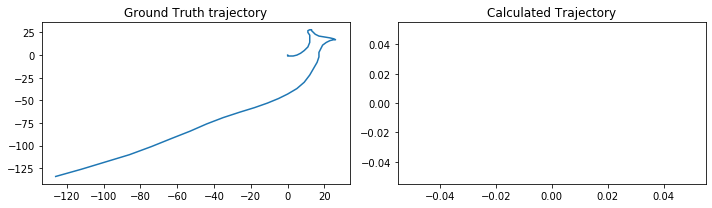

In [ ]:
# out.release()
cum_mov_true = np.cumsum(move_true, axis=0) 
cum_mov_calc = np.cumsum(move_calc, axis=0) 

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(cum_mov_true[:,0], cum_mov_true[:,1])
axes[0].set_title('Ground Truth trajectory')
axes[1].plot(cum_mov_calc[:,1], cum_mov_calc[:,0])
axes[1].set_title('Calculated Trajectory')

plt.tight_layout()
plt.show()